In [1]:
import pyart
import glob
import os
import numpy as np
from pyhail import hsda, hdr, mesh, common

import warnings
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [50]:
odim_path   = '/g/data1a/kl02/jss548/daily_mesh/odim'
grid_path   = '/g/data1a/kl02/jss548/daily_mesh/grid'
sonde_ffn   = '/g/data1a/kl02/jss548/daily_mesh/snd/ADEL_20161111_00.nc'
fieldn      = {'dbzh':'DBZH',
               'hail_ke':'HAIL_KE',
               'shi':'SHI',
               'posh':'POSH',
               'mesh':'MESH'}
d_dbzh      = -7.8 #negative means hot

In [ ]:
#generate mesh grids

odim_file_list = sorted(glob.glob(odim_path + '/*.h5'))
for odim_file in odim_file_list:
    
    print('processing ', odim_file)
    
    radar = pyart.aux_io.read_odim_h5(odim_file, file_field_names=True)
    
    ###########################################################
    # Gridded Processing and Output
    ###########################################################
    
    #apply ref offset
    ref_data = radar.fields[fieldn['dbzh']]['data']
    radar.fields[fieldn['dbzh']]['data'] = ref_data + d_dbzh

    #grid
    grid_shape  = (41, 301, 301)
    grid_limits = ((0, 20000), (-150000.0, 150000.0), (-150000.0, 150000.0))
    grid_roi    = 2000
    
    #genreate grid object
    grid = pyart.map.grid_from_radars(
        radar,
        grid_shape = grid_shape,
        grid_limits = grid_limits,
        roi_func='constant', constant_roi = grid_roi,
        fields=[fieldn['dbzh']])
    
    #MESH
    basename = os.path.splitext(os.path.basename(odim_file))[0]
    out_fn  = '_'.join([basename, 'meshgrids']) + '.nc'
    out_ffn = '/'.join([grid_path,out_fn])
    _ = mesh.main(grid, fieldn, out_ffn, sonde_ffn, [], ref_name=fieldn['dbzh'], False)
    
print('finished')

In [ ]:
#loop through files and collate mesh grid
grid_file_list = sorted(glob.glob(grid_path + '/*.nc'))

#load first frame
grid          = pyart.io.read_grid(grid_file_list[0])
max_mesh_grid = grid.fields[fieldn['mesh']]['data'][0,:,:]

#collate
for grid_file in grid_file_list[1:]:
    print(grid_file)
    grid       = pyart.io.read_grid(grid_file)
    mesh_grid  = grid.fields[fieldn['mesh']]['data'][0,:,:]
    max_mesh_grid = np.ma.max(np.ma.dstack((max_mesh_grid, mesh_grid)), axis=2)
    print(np.max(max_mesh_grid))
    
#use last grid object to replace mesh with max_mesh
max_mesh_out        = np.zeros_like(grid.fields[fieldn['mesh']]['data'].filled(0))
max_mesh_out[0,:,:] = max_mesh_grid
MESH_field          = {'data': max_mesh_out, 'units': 'mm', 'long_name': 'Maximum Expected Size of Hail',
                    'standard_name': 'MESH', 'comments': 'Witt et al. 1998, only valid in the first level'}   
grid.add_field(fieldn['mesh'], MESH_field, replace_existing=True)

print('finished')

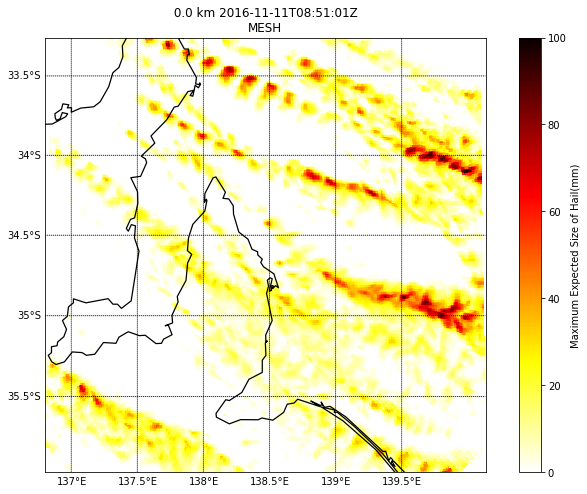

In [49]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

#setup vars
var  ='MESH'
vmin = 0
vmax = 150
cmap = 'hot_r'

#set up plotting domain
level     = 0
max_lat   = -33
min_lat   = -36
min_lon   = 137
max_lon   = 140
lat_lines = np.arange(-33, -36, -.5)
lon_lines = np.arange(137, 140, .5)

fig = plt.figure(figsize=(12, 8), facecolor='w')
ax  = plt.subplot(111)
display = pyart.graph.GridMapDisplay(grid)
display.plot_basemap(ax = ax, lon_lines = lon_lines, lat_lines = lat_lines,
                     max_lat = max_lat, min_lat =min_lat, min_lon = min_lon, max_lon = max_lon,
                     resolution = 'i')
display.plot_grid(var, level=level, vmin=vmin, vmax=vmax, cmap=cmap, 
                    mask_outside=True, ax=ax)

plt.savefig('test.png',dpi=100)